# Sequential Decisions

[Wolfram Barfuss](https://wbarfuss.github.io) | [University of Bonn](https://www.uni-bonn.de) | 2024/2025 <br>
▶ **Complex Systems Modeling of Human-Environment Interactions**

## Motivation | **Sequential decision-making under uncertainty**

We will introduce the model framework of **Markov Decision Processes (MDPs)** to model sequential decision-making under uncertainty. 
MDPs are a powerful tool to model decision-making processes in various applications, such as robotics, finance, and environmental management. 



**MDPs highlight the trade-off between current and future wellbeing in the presence of uncertainty**.

* Markov Decision Processes (MDPs) are models for sequential decision-making when outcomes are uncertain. 
* They extend [Markov Chains](02.04-StateTransitions.ipynb) by a single **agent**, executing an *action* at each time step, trying to optimize its long-term wellbeing.

### **Applications** in human-environment interactions

MDPs are widely used in environmental management and conservation biology to model the trade-off between current and future wellbeing in the presence of uncertainty [@Williams2009; @MarescotEtAl2013]. Application areas cover the whole  spectrum of **natural resource ecology, management, and conservation**, including

* **forestry and forest management**
* **fisheries and aquatic management**
* **wildlife and range management**
* **weeds, pest, and disease control**

In ecology, the term *stochastic dynamic programming* (SDP) is often used to refer to both the mathematical model (MDP) and its solution techniques (SDP per see).

### **Advantages** of Markov decision processes

Using MDPs to model human-environment interactions has several advantages:

* **inherently stochastic** - to account for uncertainty
* **nonlinear** - to account for structural changes
* **agency** - to account for *human behavior*
* **future-looking** - to account for the trade-off between short-term and long-term
* **feedback** - between one agent and the environment

In addition to these structural advantages, MDPs can also be solved in a computationally efficient way using a variety of algorithms, such as dynamic programming and reinforcement learning. This makes them also a **scalable** modeling framework. However, as **our focus** lies on **transparent analysis and interpretation**, we will focus on **minimalistic models** and won't cover the computational aspects. But in principle, MDPs can be used to model high-dimensional systems with many states and actions.

### **Learning goals**

After this lecture, students will be able to:

* **Describe** the elements of a Markov Decision Process (MDP) and how they relate to applications in human-environment interactions
* **Simulate** and **visualize** the time-evolution of an MDP
* **Explain** what value functions are, why they are useful, and how to relate to the agent's goal and Bellman equation.
* **Compute** value functions and **visualize** the best policy in simple MDPs


## **Markov Decision Process**es (MDPs)

In [1]:
import numpy as np  
import sympy as sp
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed

import matplotlib.style as style; style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (7.8, 2.5); plt.rcParams['figure.dpi'] = 300
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]  # get the first color of the default color cycle
plt.rcParams['axes.facecolor'] = 'white'; plt.rcParams['grid.color'] = 'gray'; plt.rcParams['grid.linewidth'] = 0.25; 

Graphically, a Markov decision process can be represented by the agent-environment interface in @fig-AEi.

![Agent-Environment Interface](images/03.01-AgentEnvironment.dio.png){#fig-AEi}


Formally, we define a Markov Decision process by the following elements:

* A discrete-time variable $t=0,1,2,\dots$
* A discrete set of **contexts** or **states** $\mathcal S = \{S_1, \dots, S_Z\}$.
* A discrete set of **options** or **actions** $\mathcal A = \{A_1, \dots, A_M\}$.
* A transition function $T: \mathcal S \times \mathcal A \times \mathcal S \rightarrow [0,1]$.
    * $T(s, a, s')$ is the transition probability from current state $s$ to the next state $s'$ under action $a$.
* A **welfare** or **reward** function $R: \mathcal S \times \mathcal A \times \mathcal S \rightarrow \mathbb R$.
    * $R(s, a, s')$ is the current/immediate/short-term reward the agent receives when executing action $a$ in state $s$ and transitioning to state $s'$.
* The agent's **goal** or **gain** function $G$, including a discount factor $\gamma \in [0, 1)$, denoting how much the agent cares for future rewards
* The agent's **policy** or **strategy** $x: \mathcal S \times \mathcal A \rightarrow [0,1]$.

### Example model **overview**

We will illustrate the concept of MDPs using a simple example [@BarfussEtAl2018], modeling the trade-off between short-term gains and environmental collapse with long-term consequences for the decision-maker's wellbeing.

![Risk-reward dilemma](images/03.01-RiskRewardDilemma.dio.png)


### States and actions

The environment consists of two states, $\mathcal S = \{\textsf{p}, \textsf{d}\}$, representing a **prosperous** and a **degraded** state of the environment. 


In [2]:
state_set = ['prosperous', 'degraded']; p=0; d=1

We also defined two Python variable `p=0` and `d=1` to serves as readable and memorable indices to represent the environmental contexts.

The agent can choose between two actions, $\mathcal A = \{\textsf{f}, \textsf{r}\}$, representing a **safe** and a **risky** decision.

In [3]:
action_set = ['safe', 'risky']; f=0; r=1

Likewise, we define two Python variables, `f=0` and `r=1`, to serve as readable and memorable indices to represent the agent's actions. We represent the *safe* action with the *f* instead of the *s* to avoid confusion with the state *s*.

### **Transitions** | Environmental dynamics

The **environmental dynamics**, i.e., the transitions between environmental state contexts are modeled by two parameters, a collapse probability, $p_c$, and a recovery probability, $p_r$.

Let's assume the following default values,

In [4]:
pc = 0.05
pr = 0.025

We implement the transitions as a three-dimensional array or **tensors**, with dimensions $Z \times M \times Z$, where $Z$ is the number of states and $M$ is the number of actions.

In [5]:
T = np.zeros((2,2,2))

The cautious action guarantees to remain in the prosperous state, $T(\mathsf{p,f,p})=1$. Thus, the agent can avoid the risk of environmental collapse by choosing the cautious action, $T(\mathsf{p,f,d})=0$.

In [6]:
T[p,f,d] = 0
T[p,f,p] = 1   

The risky action risks the collapse to the degraded state, $T(\mathsf{p,r,d}) = p_c$, with a collapse probability $p_c$. Thus, with probability $1-p_c$, the environment remains prosperous under the risky action, $T(\mathsf{p,r,p}) = 1-p_c$.

In [7]:
T[p,r,d] = pc
T[p,r,p] = 1-pc

At the degraded state, recovery is only possible through the cautious action, $T(\mathsf{d,f,p})=p_r$, with recovery probability 
$p_r$. Thus, with probability $1-p_r$, the environment remains degraded under the cautious action, $T(\mathsf{d,f,d})=1-p_r$.

In [8]:
T[d,f,p] = pr
T[d,f,d] = 1-pr

Finally, the risky action at the degraded state guarantees a lock-in in the degraded state, $T(\mathsf{d,r,d})=1$. Thus, the environment cannot recover from the degraded state under the risky action, $T(\mathsf{d,r,p})=0$. 

In [9]:
T[d,r,p] = 0
T[d,r,d] = 1

Last, we make sure that our transition tensor is normalized, i.e., the sum of all transition probabilities from a state-action pair to all possible next states equals one, $\sum_{s'} T(s, a, s') = 1$.

In [10]:
assert np.allclose(T.sum(-1), 1.0)

All together, the transition tensor looks as follows:

In [11]:
T

array([[[1.   , 0.   ],
        [0.95 , 0.05 ]],

       [[0.025, 0.975],
        [0.   , 1.   ]]])

### **Rewards** | Short-term welfare
The rewards or welfare the agent receives represent the ecosystem services the environment provides. It is modeled by three parameters: a safe reward $r_s$, a risky reward $r_r>r_s$, and a degraded reward $r_d<r_s$. We assume the following default values,

In [12]:
rs = 0.8
rr = 1.0
rd = 0.0

As the transition, we implement the rewards as a three-dimensional array or **tensor**, with dimensions $Z \times M \times Z$, where $Z$ is the number of states and $M$ is the number of actions.

In [13]:
R = np.zeros((2,2,2))

The cautious action at the prosperous state guarantees the safe reward, $R(\mathsf{p,f,p}) = r_s$,

In [14]:
R[p,f,p] = rs

The risky action at the prosperous leads to the risky reward if the environment does not collapse, $R(\mathsf{p,r,p}) = r_r$,

In [15]:
R[p,r,p] = rr

Yet, whenever the environment enters, remains, or leaves the degraded state, it provides only the degraded reward $R(\mathsf{d,:,:}) = R(\mathsf{:,:,d}) = r_d$, where $:$ denotes all possible states and actions.

In [16]:
R[d,:,:] = R[:,:,d] = rd

Together, the reward tensor looks as follows:

In [17]:
R

array([[[0.8, 0. ],
        [1. , 0. ]],

       [[0. , 0. ],
        [0. , 0. ]]])

### Policy
For now, we have not contemplated how the agent should behave. Therefore, to understand how transitions, rewards, and policies are related, let us simulate the MDP using a random policy. 

We will implement a policy as a two-dimensional array or **tensor**, with dimensions $Z \times M$, where $Z$ is the number of states and $M$ is the number of actions.

In [18]:
X = np.random.rand(2,2)  # random values between 0 and 1

A policy has to be a probability distribution over actions for each state, $\sum_a X(s, a) = 1$. To ensure this, we normalize the policy tensor,

In [19]:
X = X / X.sum(axis=-1, keepdims=True) 

and test, if the policy is a valid probability distribution by asserting that the sum of all probabilities over actions is equal to one,

In [20]:
assert np.allclose(X.sum(-1), 1.0)

Together, the policy tensor looks as follows:

In [21]:
X

array([[0.32878922, 0.67121078],
       [0.9813571 , 0.0186429 ]])

We convert this logic into a Python function, that returns a random policy for a given number of states and actions,

In [22]:
def random_policy(Z=2, M=2):
    X = np.random.rand(Z,M)  # random values
    X = X/X.sum(axis=-1, keepdims=True) # normalize values, such that
    assert np.allclose(X.sum(-1), 1.0) # X is a proper probability distribution
    return X

For example, a random policy for our example MDP with two states and two actions looks as follows:

In [23]:
np.random.seed(42)
random_policy(M=2, Z=2)

array([[0.28261752, 0.71738248],
       [0.55010153, 0.44989847]])

This completes all definitions required for an MDP. We can now simulate the MDP by iterating over time steps and applying the policy to the current state.

## Simulation

### Stochastic simulation

As in the case of [Markov chains](02.04-StateTransitions.ipynb), we can simulate the MDP by drawing random numbers. We draw the actions according to the policy and the next state according to the transition probabilities. The reward is then a result of the current state, the current action, and the next state. We implement this as a Python function that takes the transition tensor, the reward tensor, the policy tensor, the initial state, and the number of time steps as input arguments.

In [24]:
def simulate_markov_decision_process(TransitionTensor, RewardTensor, Policy, InitialState, NrTimeSteps):   
    state_trajectory = []
    reward_trajectory = []
    state = InitialState
    
    for t in range(0, NrTimeSteps):
        # Choose random action according to policy:
        action = np.random.choice([f, r], p=Policy[state]) 
        # Transition to new state:
        state_ = np.random.choice([p, d], p=TransitionTensor[state][action]) 
        # Record reward:
        reward = RewardTensor[state, action, state_] 
        # Update state:
        state = state_  
        # Store in trajectories
        state_trajectory.append(state);
        reward_trajectory.append(reward) 

    return np.array(state_trajectory), np.array(reward_trajectory)

We execute the simulation and visualize the time-evolution of the MDP's environmental state and agent's rewards.


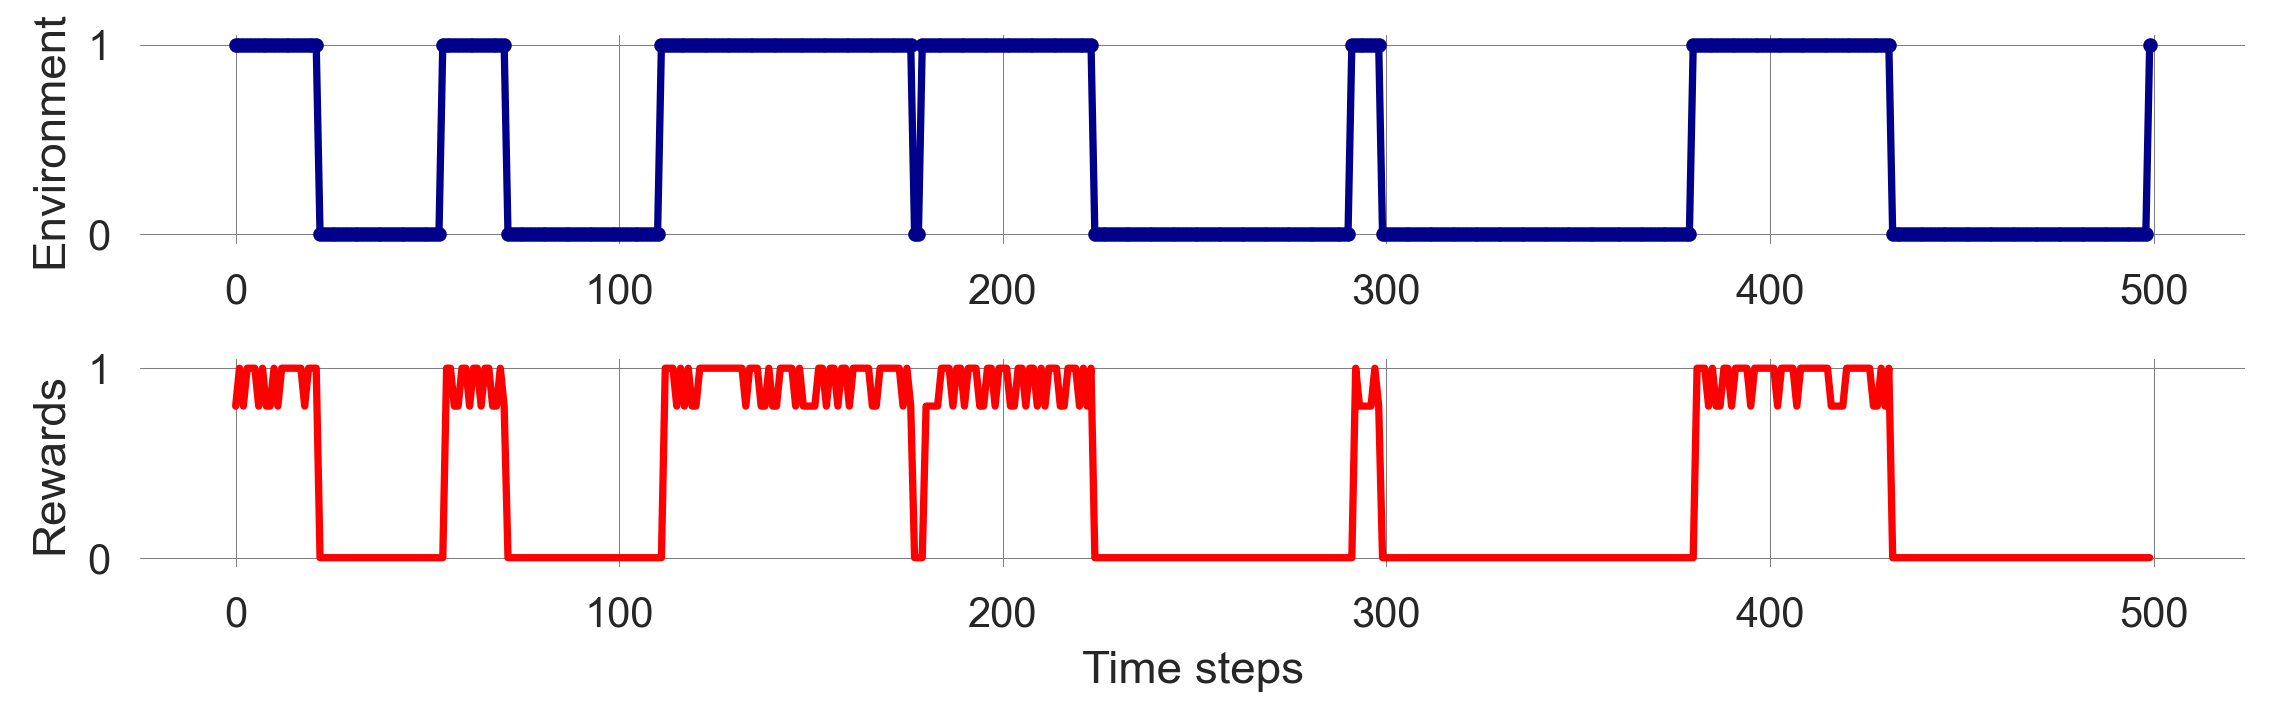

In [25]:
np.random.seed(1818)
state_trajectory, reward_trajectory = simulate_markov_decision_process(T, R, X, 0, 500)

fig, axes = plt.subplots(2,1)
axes[0].plot(1-np.array(state_trajectory), ls='-', marker='.', color='Darkblue')
axes[1].plot(reward_trajectory, color='Red'); axes[0].set_ylabel('Environment'); axes[1].set_ylabel('Rewards'); axes[1].set_xlabel('Time steps'); plt.tight_layout();

We observe the same stochastic nature of the simulation as with Markov chains. Furthermore, the agent's rewards fluctuate over time, depending on the environmental state and the agent's actions. The agent's rewards are higher in the prosperous state and lower in the degraded state.

Can we make sense of the stochasticity by computing averages over many simulations?

### Ensemble simulation

Let's repeat the previous simulation to create an **ensemble of stochastic simulation runs**. Let's assume we want an ensemble of 250 runs.

In [26]:
state_ensemble = []
reward_ensemble = []
for _ in range(250):
    state = 0
    state_trajectory, reward_trajectory =\
        simulate_markov_decision_process(T, R, X, 0, 500)
    state_ensemble.append(state_trajectory)
    reward_ensemble.append(reward_trajectory)
state_ensemble = np.array(state_ensemble)
reward_ensemble = np.array(reward_ensemble)

It is always a good idea to investigate the object one has just created for consistency, for instance, checking the shape of the ensemble.

In [27]:
print(state_ensemble.shape, reward_ensemble.shape)

(250, 500) (250, 500)


For each ensembel, the first dimension of the ensemble is the number of runs, the second dimension is the number of time steps.

Visualizing the ensemble by takeing the mean over the first dimension (using `ensemble.mean(axis=0)`), 

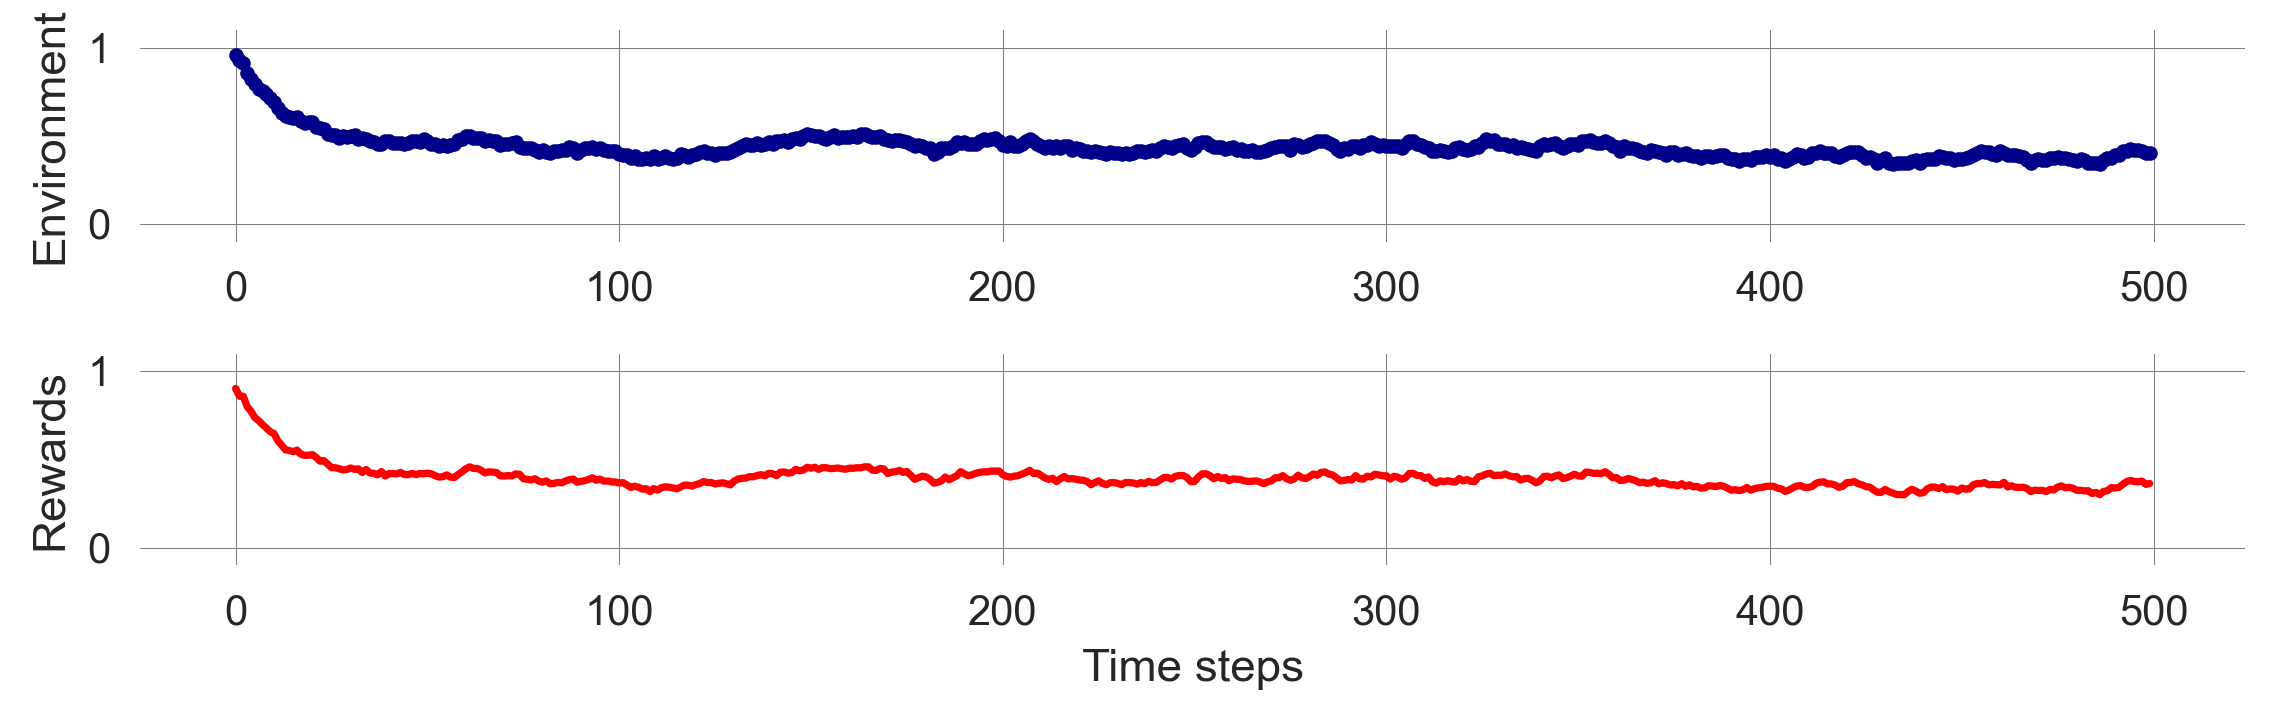

In [28]:
#| label: fig-mdp-ensemble
fig, axes = plt.subplots(2,1)
axes[0].plot(1-state_ensemble.mean(0), ls='-', marker='.', color='Darkblue')
axes[1].plot(reward_ensemble.mean(0), color='Red');
axes[0].set_ylabel('Environment'); axes[1].set_ylabel('Rewards'); 
axes[0].set_ylim(-0.1,1.1); axes[1].set_ylim(-0.1,1.1); axes[1].set_xlabel('Time steps');
plt.tight_layout();

@fig-mdp-ensemble shows the ensemble average of the environmental state and the agent's rewards over time. The ensemble average is smoother than the individual runs, indicating that the stochasticity averages out over many runs. This observation suggests that we can work with the MDP in the same way as a Markov chain, simulating the time evolution of the state **distribution** directly.

### Distribution trajectory

We realize that the MDP's transition tensor can be reduced to a Markov Chain's transition matrix when we fix the agent's policy:

$$
T_\mathbf{x}(s, s') := \sum_{a \in \mathcal A} x(s, a) T(s, a, s')
$$

In Python, we use the `einsum` function for that, since it gives us full control over which indices we want to execute the summation:

In [29]:
s, a, s_ = 0, 1, 2
Tss = np.einsum(X, [s,a],     # first object with indices
                T, [s,a,s_],  # second object with indices
                [s,s_])       # indices of the output
Tss

array([[0.96643946, 0.03356054],
       [0.02453393, 0.97546607]])

With the effective Markov chain transition matrix, we use the matrix update derived in [02.04-StateTransitions](02.04-StateTransitions.ipynb) to simulate how the state distribution evolves.

In [30]:
ps = [1, 0]
p_trajectory = []
for i in range(500):
    ps = ps @ Tss
    p_trajectory.append(ps)
p_trajectory = np.array(p_trajectory)

The trajectory of the state distribution has the number of time steps as the first dimension and the number of states as the second dimension.

In [31]:
p_trajectory.shape

(500, 2)

Visualizing the state distribution evolution together with the ensemble average reveals a close resembles between the two.

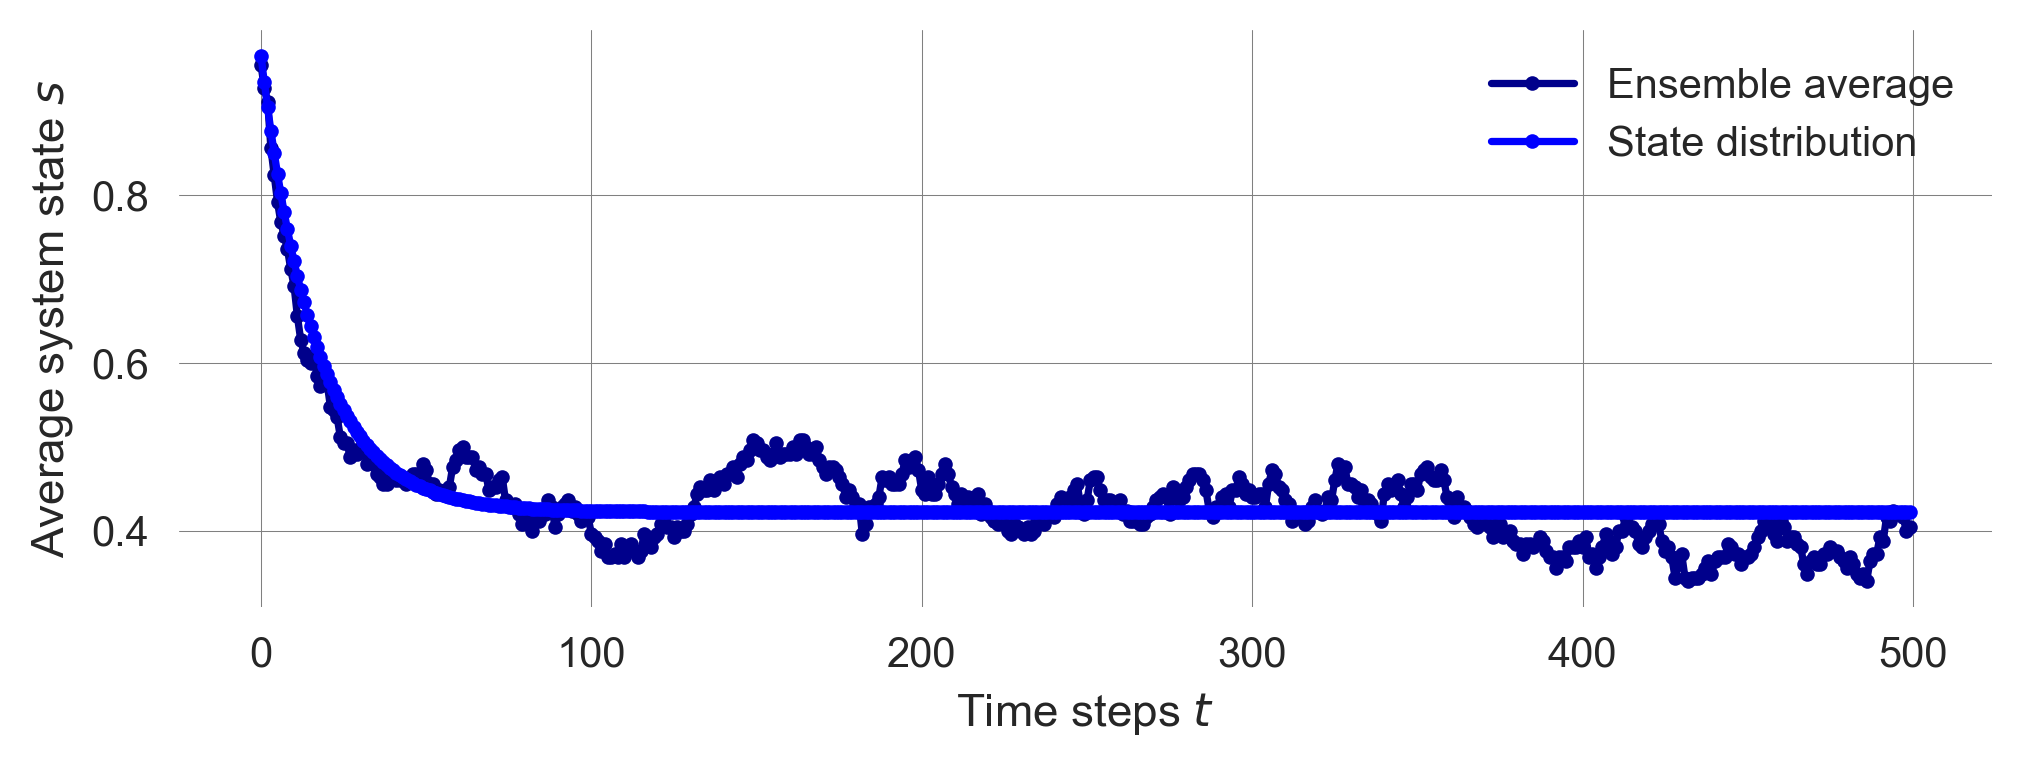

In [32]:
plt.plot(1-state_ensemble.mean(0), ls='-', marker='.', color='Darkblue',  label='Ensemble average')
plt.plot(p_trajectory[:, 0], ls='-', marker='.', color='blue', label='State distribution')
plt.xlabel('Time steps $t$'); plt.ylabel('Average system state $s$'); plt.legend();

To compute the average reward trajectory over time, we use the same logic as for the state distribution trajectory, $p_t(s)$. We compute the reward distribution by summing over the state dimension, weighted by the state distribution,

$$
\langle R_t \rangle_\mathbf{x}= \mathbb E_\mathbf{x}[r_t] = \sum_{s \in \mathcal S} \sum_{a \in \mathcal A} \sum_{s' \in \mathcal{S}}  p_t(s) x(s,a)T(s,a,s')R(s,a,s'),
$$

where $\mathbb E_\mathbf{x}[\cdot]$ denotes the expected value of a random variable $\cdot$ given the agent follows policy $\mathbf x$.


You see how, in this equation on the right hand side, the information flows from the left to the right. The state distribution $p_t(s)$ is multiplied with the policy $x(s,a)$ to get the probability of taking action $a$. This probability is then multiplied with the transition probability $T(s,a,s')$ to get the probability of transitioning to state $s'$. Finally, this probability is multiplied with the reward $R(s,a,s')$ to get the expected reward.

We use the `einsum` function to convert this logic into Python,

In [33]:
s, a, s_, t = 0, 1, 2, 3
r = np.einsum(p_trajectory, [t, s],
              X, [s,a],     
              R, [s,a,s_],
              T, [s,a,s_],  
              [t])  # output only in time dimension

We check that the average-reward trajectory is only a one-dimensional array, with the number of timesteps as the first dimension.

In [34]:
r.shape

(500,)

Visualizing the average-reward distribution evolution together with the ensemble average reveals a close resemblance between the two.

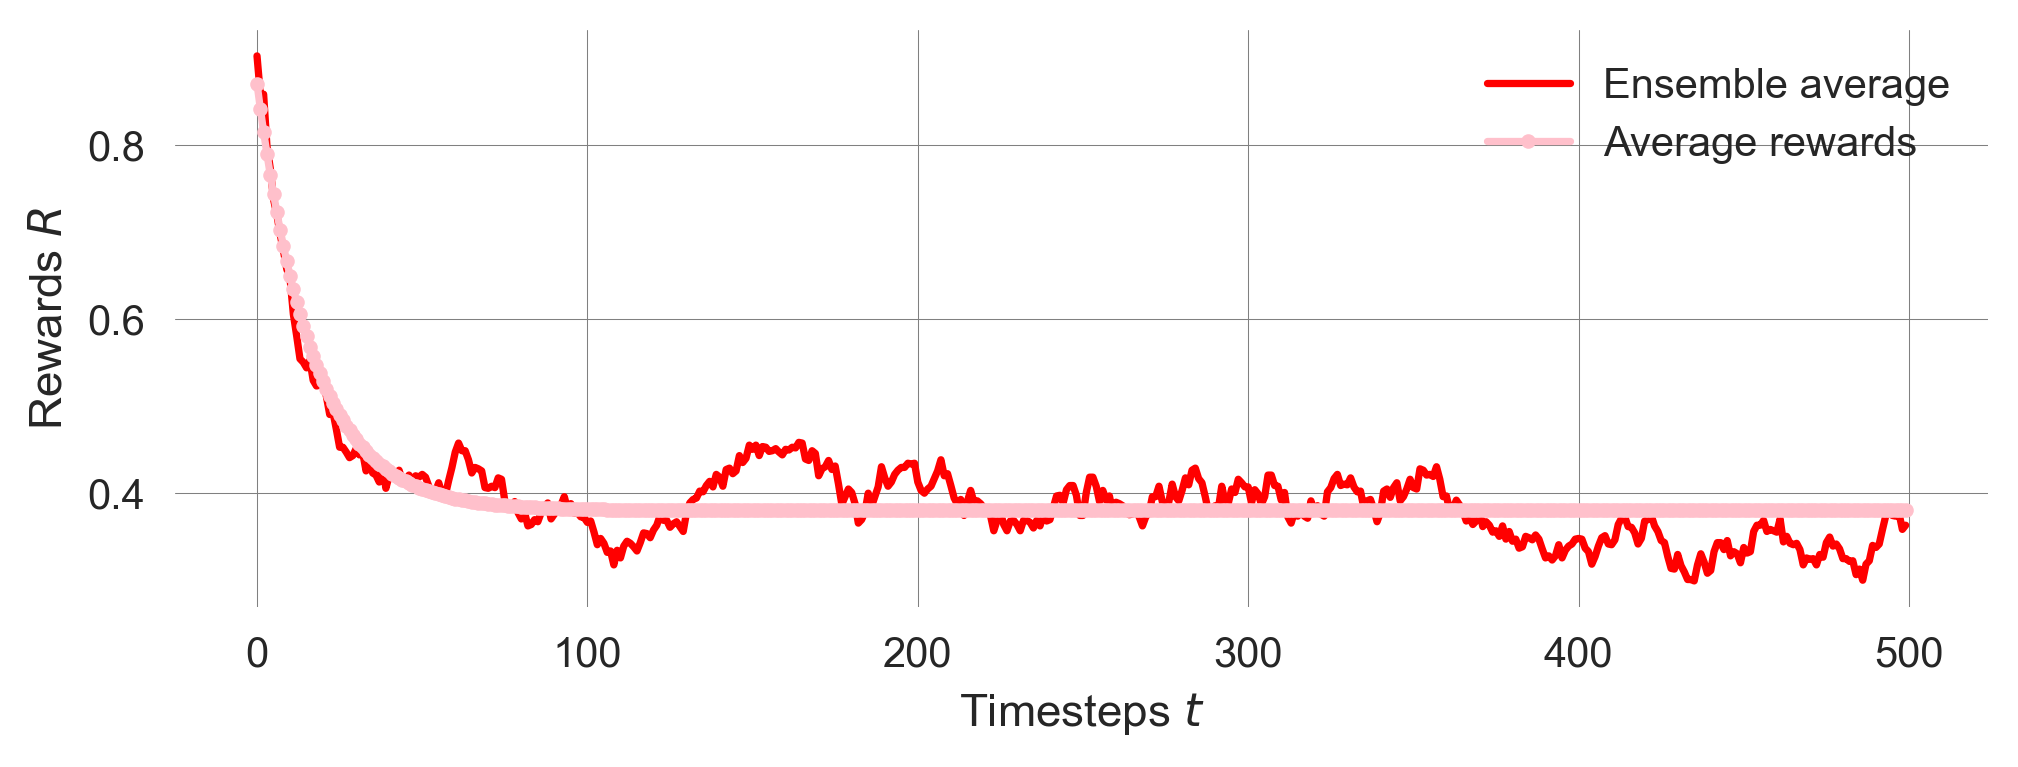

In [35]:
plt.plot(reward_ensemble.mean(0), color='Red', label='Ensemble average');
plt.plot(r, ls='-', marker='.', color='pink', label='Average rewards');
plt.xlabel('Timesteps $t$'); plt.ylabel('Rewards $R$'); plt.legend();

Thus, we can also calculate the stationary distribution of an MDP given a policy $\mathbf x$ in the same way as for a [Markov chain](02.04-StateTransitions.ipynb).

## Goals and values

In the Markov Decision Process framework, the agent's **purpose** or goal is formalized within the *reward signal*, flowing from the environment to the agent [@SuttonBarto2018]. At each time step, the agent the reward is represented by a single number $R_t \in \mathbb R$. Informally, the agent's goal is to maximize the total amount of reward it receives over time. This may entail choosing actions that yield less immediate rewards to get more rewards in the future.

Representing the agent's goal by a series of single numbers might seem limiting. However, in practice, it has proven itself 
flexible and widely applicable. It also aligns well with the unidimensional concepts of **utility** in economics [@SchultzEtAl2017] and **fitness** in biological or cultural evolution.

<!-- primary vs. secondary rewards  [@HoffmanYoeli2022] 
use reward function to encode goal, behavior follows
-->

<!-- reward are not necessarly physical quantities which we can measure -->

### Goal functions

How do we translate our informal definition of the agent's goal as maximizing the total amount of reward into a formal mathematical equation? 

**Finite-horizon goal.** The simplest case for a goal function $G_t$ is to sum up all rewards the agent receives from timestep $t$ onwards until the final time step $T$,
$$
G_t := R_{t+1} + R_{t+2} + R_{t+3} + \cdots + R_T = \sum_{\tau=t+1}^T R_\tau.
$$

This definition makes sense only if we have a clearly defined final state, such as the end of a board game, the completion of an individual project, or the end of an individual's life. However, in human-environment interaction in the context of sustainability transitions, we are interested in the long-term future without a clear final state. In these cases, we cannot use the goal definition from above as with $T=\infty$, the sum $G_t$ itself could easily be infinite for multiple reward sequences, which would leave the agent without guidance on which reward sequence yields a higher $G_t$ and, hence, what to do. 

*For example*, on average, our ensemble of stochastic simulations yields a total finite-horizon gain of

In [36]:
reward_ensemble.sum(axis=1).mean()

197.87679999999997

**Discounted goal.** We solve this problem of diverging gains $G_t$ with the concept of **temporal discounting**. We revise our informal definition of the agent's goal: The agent tries to select actions to maximize the sum of discounted future rewards [@SuttonBarto2018]. The goal function then becomes,

$$
G_t := R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots = \sum_{\tau=t}^\infty \gamma^\tau R_{t+\tau+1},
$$

where $\gamma \in [0, 1)$ is the **discount factor**. The discount factor determines how much the agent cares about future rewards. A discount factor of $\gamma=0$ means that the agent only cares about the immediate reward, while as the discount factor approaches $\gamma \rightarrow 1$, the agent takes future rewards into account more strongly and becomes more farsighted.


*For example,* the discounted gain with a discount factor of $\gamma=0.9$ of the last ensemble run is

In [37]:
np.sum([0.9**t * reward_ensemble[-1, t] for t in range(500)])

9.254059133343878

Temporal discounting is a widely used concept in (environmental) economics, psychology, and neuroscience to model human decision-making. It implies that welfare experienced in the future is worth less to the agent than the same amount of welfare experienced now. This concept is used both as a **normative** and **descriptive** model of decision-making. 

One reason for temporal discounting is the **uncertainty** about the future. The future is uncertain, and the agent might not be around to experience future rewards. In fact, $\gamma$ can be interpreted as the probability that the agent will be around to experience future rewards. 

The primary value of temporal discounting and the discount factor for us in our quest to develop integrated system models of human-environment interactions is its ability to **model the trade-off between present and future welfare**. This trade-off is at the heart of many sustainability transitions, such as the trade-off between short-term economic gains and long-term environmental degradation.


*For example,* let's assume the agent receives a constant reward stream of $R_t=1$ for all timesteps $t$. We compare the so-called (net) present value at timestep $t$ for different discount factors $\gamma$. We also compute the sum of the discounted rewards for the infinite future, $G_t$.

Discount factor 0.10: Total   1.1
Discount factor 0.50: Total   2.0
Discount factor 0.90: Total  10.0
Discount factor 0.99: Total 100.0


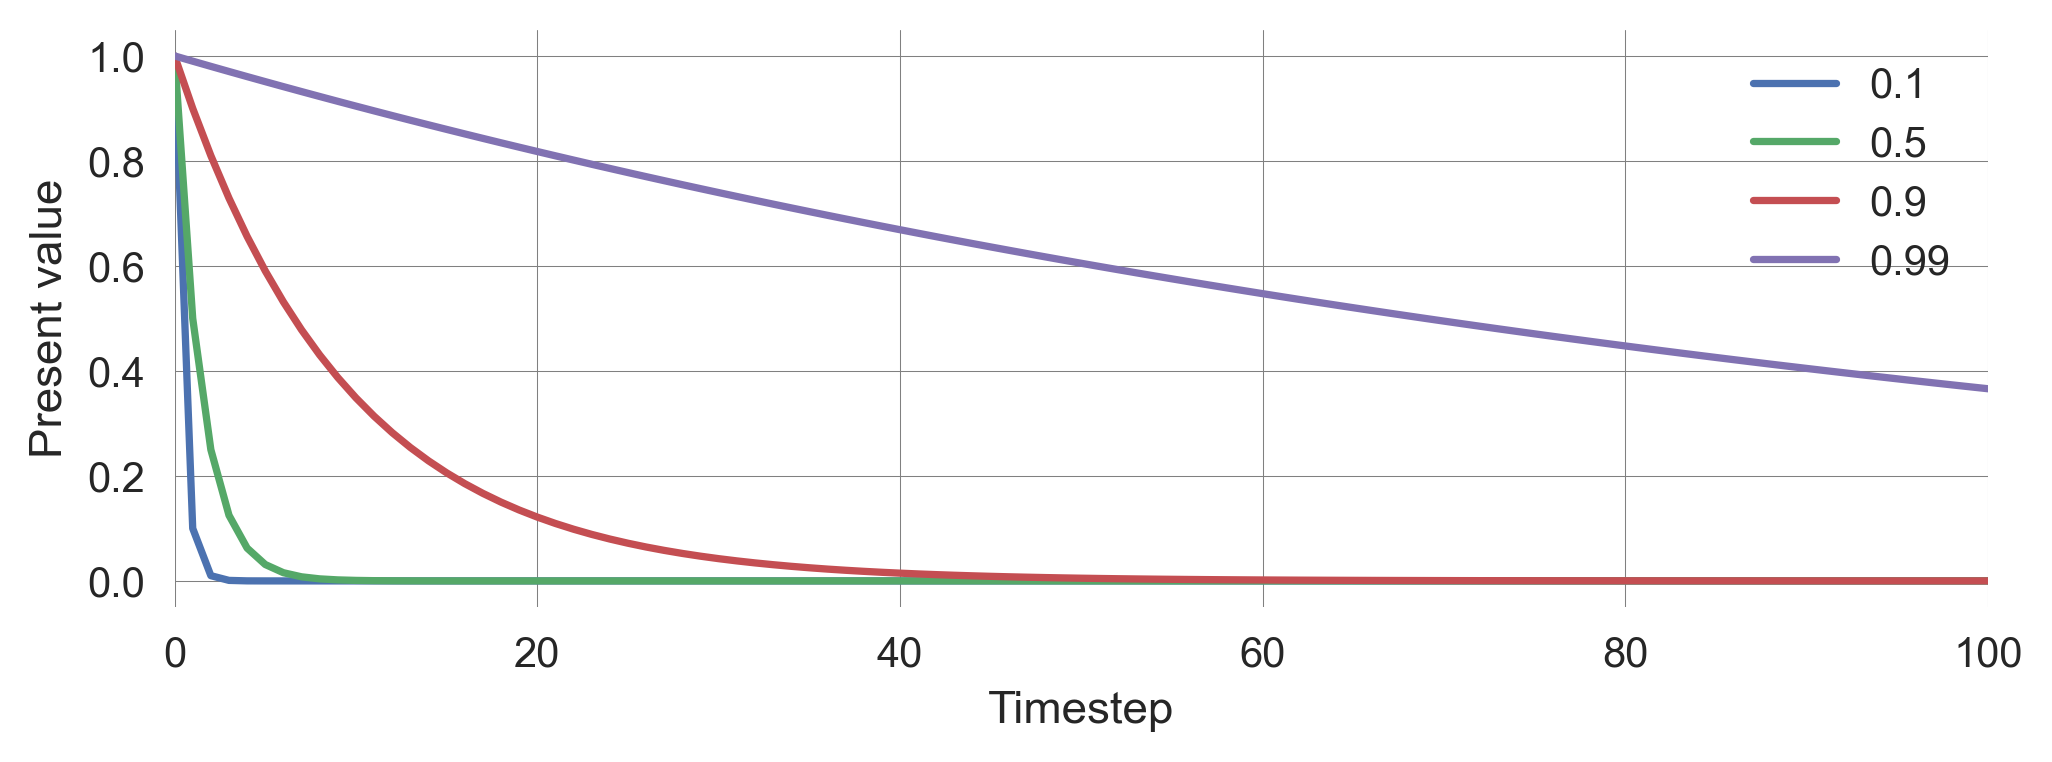

In [38]:
#| label: fig-discountfactors
for discountfactor in [0.1, 0.5, 0.9, 0.99]:
    summands = [discountfactor**t for t in range(10000)]
    plt.plot(summands, label=discountfactor)

    total_value = np.sum(summands)
    print("Discount factor {dcf:3.2f}: Total {total:5.1f}"\
        .format(dcf=discountfactor, total=total_value))

plt.legend(); plt.ylabel('Present value'); plt.xlabel('Timestep'); 
plt.xlim(0,100);

Here, we used the Python string method `format` to print the results in a readable way. It can be used to insert variables into a string. The curly brackets `{}` are placeholders for the variables, and the variables are passed to the `format` method as arguments. The colon `:` inside the curly brackets is used to format the output. For example, `:3.2f` formats the number as a floating-point number with three digits before and two digits after the decimal point.

***Normalized* goal**. To account for the fact that the total value depends on the level of discounting, even if the reward stream is constant, we can normalize the goal as follows,

$$ G_t = (1-\gamma) \sum_{\tau=t}^\infty \gamma^\tau R_{t+\tau+1},$$

where $1-\gamma$ is a normalizing factor and $R_{t+\tau+1}$ is the reward received at time step $t+\tau+1$.

In [39]:
for dcf in [0.1, 0.5, 0.9, 0.99]:
    summands = [dcf**t for t in range(10000)]
    normalizing = 1-dcf
    total_value = normalizing * np.sum(summands)
    print("Discount factor {dcf:3.2f}: Total {total:5.1f}".format(dcf=dcf, total=total_value))

Discount factor 0.10: Total   1.0
Discount factor 0.50: Total   1.0
Discount factor 0.90: Total   1.0
Discount factor 0.99: Total   1.0


With normalization, the discount factor parameter $\gamma$ expresses how much the agent **cares for the future** without influencing the scale of the total value. That way, the outcomes of different discount factors can be **compared** with each other.

*For example,* the normalized discounted gain with a discount factor of $\gamma=0.9$ of the last ensemble run is

In [40]:
dcf = 0.9
(1-dcf) * np.sum([dcf**t * reward_ensemble[-1, t] for t in range(500)])

0.9254059133343876

**Bellman equation**. Regardless of the goal formulation, the agent's gains $G_t$ at successive time steps relate to each other in an important way:

\begin{align}
G_t &= (1-\gamma) \sum_{\tau=t}^\infty \gamma^\tau R_{t+\tau+1}\\
   &= (1-\gamma) \left(R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \gamma^3 R_{t+4} \cdots \right)\\
   &= (1-\gamma) \left(R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + \gamma^2 R_{t+4} \cdots) \right)\\
   &= (1-\gamma) R_{t+1} + \gamma (1-\gamma) (R_{t+2} + \gamma R_{t+3} + \gamma^2 R_{t+4} \cdots) \\
   &= (1-\gamma) R_{t+1} + \gamma G_{t+1},
\end{align}

The gain $G_t$ is composed of the current short-term reward and the (discounted) value of the future gains. This recursive relationship is known as the **Bellman equation** and is the foundation of many solution methods for MDPs, such as dynamic programming and reinforcement learning.

*For example,* we can test the Bellman equation by comparing the gain at time step $t$ with the short-term reward at time step $t$ and the gain at time step $t+1$.

In [41]:
dcf = 0.9
G0 = (1-dcf) * np.sum([dcf**t * reward_ensemble[-1, t] for t in range(0, 500)])
G1 = (1-dcf) * np.sum([dcf**t * reward_ensemble[-1, t+1] for t in range(0, 499)])

np.allclose((1-dcf) * reward_ensemble[-1, 0] + dcf * G1, G0)

True

Why does that work even though we have a finite time horizon of 500 simulation timesteps here? From @fig-discountfactors we observe that for a discount factor $\gamma=0.9$, the contributions of rewards for timesteps above $t>100$ are practically zero. So, with a simulation time of 500 timesteps, we are well above the time horizon the agent cares about. This example illustrates not only the power of the Bellman equation. It also shows how a discount factor induces a timescale the agent cares about.

Goals or gains are defined over individual reward streams or trajectories. These may be stochastic beyond the agent's control. Therefore, the agent's course of action should consider the **expected** gains, i.e., the average gains over all possible reward streams, given a policy $\mathbf x$. 

### Value functions

**Value functions are defined to be the expected gain $G_t$ for a policy $\mathbf x$, given a state or state-action pair.** They are helpful in finding a good policy since the best policy will yield the highest value.

Given a policy $\mathbf x$, we define the **state value**, $v_{\mathbf x}(s)$,  as the expected gain, $\mathbb E_\mathbf{x}[ G_t | S_t = s]$, when starting in state $s$ and the following the policy $\mathbf x$,

$$
v_\mathbf{x}(s) := \mathbb E_\mathbf{x}[ G_t | S_t = s] = (1-\gamma) \mathbb E_\mathbf{x}\left[\sum_{\tau=t}^\infty \gamma^\tau R_{t+\tau+1} | S_t = s\right], \quad \text{for all } s \in \mathcal S,
$$

Analogously, we define the **state-action value**, $q_\mathbf{x}(s, a)$, as the expected gain when starting in state $s$ and executing action $a$, and from then on following policy $\mathbf x$,

$$
q_\mathbf{x}(s, a) := \mathbb E_X [G(t) | s(t) = s, a(t)=a].
$$

$$
q_\mathbf{x}(s, a) := \mathbb E_\mathbf{x}[ G_t | S_t = s, A_t = a] = (1-\gamma) \mathbb E_\mathbf{x}\left[\sum_{\tau=t}^\infty \gamma^\tau R_{t+\tau+1} | S_t = s, A_t = a\right], \quad \text{for all } s \in \mathcal S, a \in \mathcal A.
$$

**How is that useful?**

1) **State values let us compare strategies.** A strategy $\mathbf x$ is better than a strategy $\mathbf y$ iff for all states $s$: $v_\mathbf{x}(s) > v_\mathbf{y}(s)$.

2) **The best strategy yields the highest value**. At least one strategy is always better than or equal to all other strategies. That is an *optimal strategy* $\mathbf x_*$ with the *optimal state value* $v_*(s) := \max_\mathbf{x} v_\mathbf{x}(s), \forall s$.

3) **Highest state-action values indicate the best action**. If we knew the *optimal state-action value*, $q_*(s, a) := \max_\mathbf{x} q_\mathbf{x}(s,a), \forall s,a$, we can simply assign nonzero probability at each state $s$ only to actions which yield maximum value, $\max_{\tilde a} q_*(s, \tilde a)$.

The **beauty** of state(-action) **values**, in general, and optimal state(-action) values, in particular, is that they **encapsulate all relevant information about future environmental dynamics** with all inherent stochasticity **into short-term actionable numbers**.  *Relevant* means relevant to the agent regarding its goal function. State-action values represent the short-term consequences of actions in each state regarding the long-term goal.
Optimal state-action values allow for selecting the best actions, irrespective of knowing potential successor states and their values or any details about environmental dynamics. Having such values would save the agent enormous cognitive computational demands every time it must make a decision.  

The only problem we are left with is, how to compute a policy's state(-action) values?

### Bellman equation

We convert the recursive relationship of the goal function (@eq-bellman1) to state values,

\begin{align}
v_\mathbf{x}(s) &= \mathbb E_\mathbf{x} [G_t | S_t = s] \\
&= \mathbb E_\mathbf{x} \left[ (1-\gamma) R_{t+1} + \gamma G_{t+1} | S_t = s \right] \\
&= (1-\gamma) \mathbb E_\mathbf{x}[ R_{t+1} | S_t = s] + \gamma \mathbb E_\mathbf{x}[G_{t+1} | S_{t+1} = s' ] \\
&= (1-\gamma) R_\mathbf{x}(s) + \gamma \sum_{s'} T_\mathbf{x}(s,s') v_\mathbf{x}(s'),
\end{align}

where $R_\mathbf{x}(s)$ is the expected reward in state $s$ under policy $\mathbf x$ and $T_\mathbf{x}(s,s')$ is the expected transition probability from state $s$ to state $s'$ under policy $\mathbf x$. 

The expected state reward $R_\mathbf{x}(s)$ is given by

$$R_\mathbf{x}(s) = \sum_{a \in \mathcal A} \sum_{s' \in \mathcal{S}}  x(s,a)T(s,a,s')R(s,a,s'),$$

which can be neatly translated into Python using the `numpy.einsum` method.

In [42]:
s, a, s_ = 0, 1, 2  # defining indices for convenicence
Rs = np.einsum(X, [s, a], T, [s, a, s_], R, [s, a, s_], [s]); Rs

array([0.90068162, 0.        ])

The recursive equation is called the *Bellman equation* in honor of Richard Bellman and his pioneering work (Bellman 1957). The recursive relationship is exploited in several algorithmic ways to compute the values or even approximate the optimal state values. In recent years, it became possible to approximate optimal state values with deep neural networks, a technique known as *deep reinforcement learning* [@MnihEtAl2015], allowing for solving high-dimensional MDPs with many - even infinitely many - states and actions. This is a fascinating field of research, which we will not cover in this course. I recommend the interested reader to start from the excellent [introduction to reinforcement learning by @SuttonBarto2018]. 

Our focus lies on a **transparent way of modeling**  human-environment interactions. We use MDPs as a framework to improve our conceptual understanding of decision-making under uncertainty. Specifically, we exemplify that with the trade-off between short-term and long-term welfare. 

Using an MDP framework, our models are formulated in a way that - in principle - can scale to high-dimensional systems. The trade-off is, however, the computational cost of solving high-dimensional MDPs. The more complex and "realistic" a model, the less we can understand how the outcome depends on the model's specifications. 

As these model specifications are often highly uncertain in the context of sustainability and global change [@PolaskyEtAl2011], it is very **likely that we end up with an optimal policy for a wrong model** that is not useful for decision-making. It might even be harmful, conveying a false sense of optimality. This problem gets worse with the complexity of the model. The more model parameters we have to specify as the input to the model, the more sources of possible but unconscious uncertainty there is. 

Therefore, we will focus on minimalistic models but take a radical stance to account for parameter uncertainty to keep the analysis and interpretation transparent. Thus, in the following, we derive an analytical expression how to compute the state values for a given policy.

We write the Bellman equation in matrix form,

$$
\mathbf v_\mathbf{x} = (1-\gamma) \mathbf R_\mathbf{x} + \gamma \underline{\mathbf T}_\mathbf{x} \mathbf v_\mathbf{x}
$$

where $\mathbf R_\mathbf{x}$ is the vector of expected state rewards $R_\mathbf{x}(s)$, $\underline{\mathbf T}_\mathbf{x}$ is the transition matrix, and $\mathbf v_\mathbf{x}$ is the vector of state values under policy $\mathbf x$. Thus, $\mathbf v_\mathbf{x}$ and $\mathbf R_\mathbf{x}$ are vectors of dimension $Z$, i.e., the number of states, and $\underline{\mathbf T}_\mathbf{x}$ is the transition matrix of dimension $Z \times Z$.

We can solve this equation for $\mathbf v_\mathbf{x}$, 

\begin{align}
\mathbf v_\mathbf{x} &= (1-\gamma) \mathbf R_\mathbf{x} + \gamma \underline{\mathbf T}_\mathbf{x} \mathbf v_\mathbf{x} \\
\mathbf v_\mathbf{x} - \gamma \underline{\mathbf T}_\mathbf{x} \mathbf v_\mathbf{x} &= (1-\gamma) \mathbf R_\mathbf{x} \\
(\mathbb 1_Z - \gamma\underline{\mathbf T}_\mathbf{x}) \mathbf v_\mathbf{x} &= (1-\gamma) \mathbf R_\mathbf{x} \\
(\mathbb 1_Z - \gamma\underline{\mathbf T}_\mathbf{x})^{-1} (\mathbb 1_Z - \gamma\underline{\mathbf T}_\mathbf{x}) \mathbf v_\mathbf{x} &= (1-\gamma) (\mathbb 1_Z - \gamma\underline{\mathbf T}_\mathbf{x})^{-1} \mathbf R_\mathbf{x} \\
\mathbf v_\mathbf{x} &= (1-\gamma) (\mathbb 1_Z - \gamma\underline{\mathbf T}_\mathbf{x})^{-1} \mathbf R_\mathbf{x}, \\
\end{align}

where $\mathbb 1_Z$ is the identity matrix of dimension $Z$.

Thus, to compute state value, we must invert a $Z\times Z$-matrix, which is computationly infeasable for large MDPs. For low-dimensional models, however, it works perfectly fine and can even be executed analytically.

In Python, an identity matrix can be created with the `eye` function from the `numpy` package.

In [43]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

We define a function to compute the state values given a policy, a transition tensor, a reward tensor, and a discount factor. The function returns a vector of state values. We use the `inv` function from the `numpy.linalg` package to invert the matrix.

In [44]:
def compute_statevalues(
    policy_Xsa, transitions_Tsas, rewards_Rsas, discountfactor):
    s, a, s_ = 0, 1, 2  # defining indices for convenicence
    Tss = np.einsum(policy_Xsa, [s, a], transitions_Tsas, [s, a, s_], [s,s_])
    Rs = np.einsum(policy_Xsa, [s, a], transitions_Tsas, [s, a, s_], 
                   rewards_Rsas, [s, a, s_], [s])
    inv = np.linalg.inv((np.eye(2) - discountfactor*Tss))
    Vs = (1-discountfactor) * np.einsum(inv, [s,s_], Rs, [s_], [s])
    return Vs

In [45]:
Vs = compute_statevalues(X, T, R, 0.9); Vs

array([0.7220388 , 0.13059414])

Thus, in contrast to the expected state rewards, the long-term value of the degraded state is above the immediate reward of the degraded state, $r_d=0$.

In [46]:
Rs

array([0.90068162, 0.        ])

In the state value $v_{\mathbf x}(\mathsf{d})$ of the degraded state, the agent anticipates the recovery of the environment and the return to the prosperous state. Likewise, the agent anticipates the collapse of the environment and the loss of the prosperous state in the state value of the prosperous state. Hence, $v_{\mathbf x}(\mathsf{p})$ is smaller than the expected reward of the prosperous state, $R_{\mathbf x}(\mathsf{p})$. The expected state rewards only consider the immediate possible transitions, while the state values also account for the long-term consequences of these transitions. 


**How do these values depend on the discount factor $\gamma$?**

We define an array of linearly spaced values of different discount factors, 

In [47]:
discountfactors = np.linspace(0.001, 0.9999, 301)

We then compute the state value for each discount-factor value using a list comprehension,

In [48]:
values = np.array([compute_statevalues(X, T, R, dcf) for dcf in discountfactors])
values.shape

(301, 2)

We plot the state values along the discount factors on the x-axis. We also include the expected state rewards, which are independent of the discount factor.

Text(0, 0.5, 'Value')

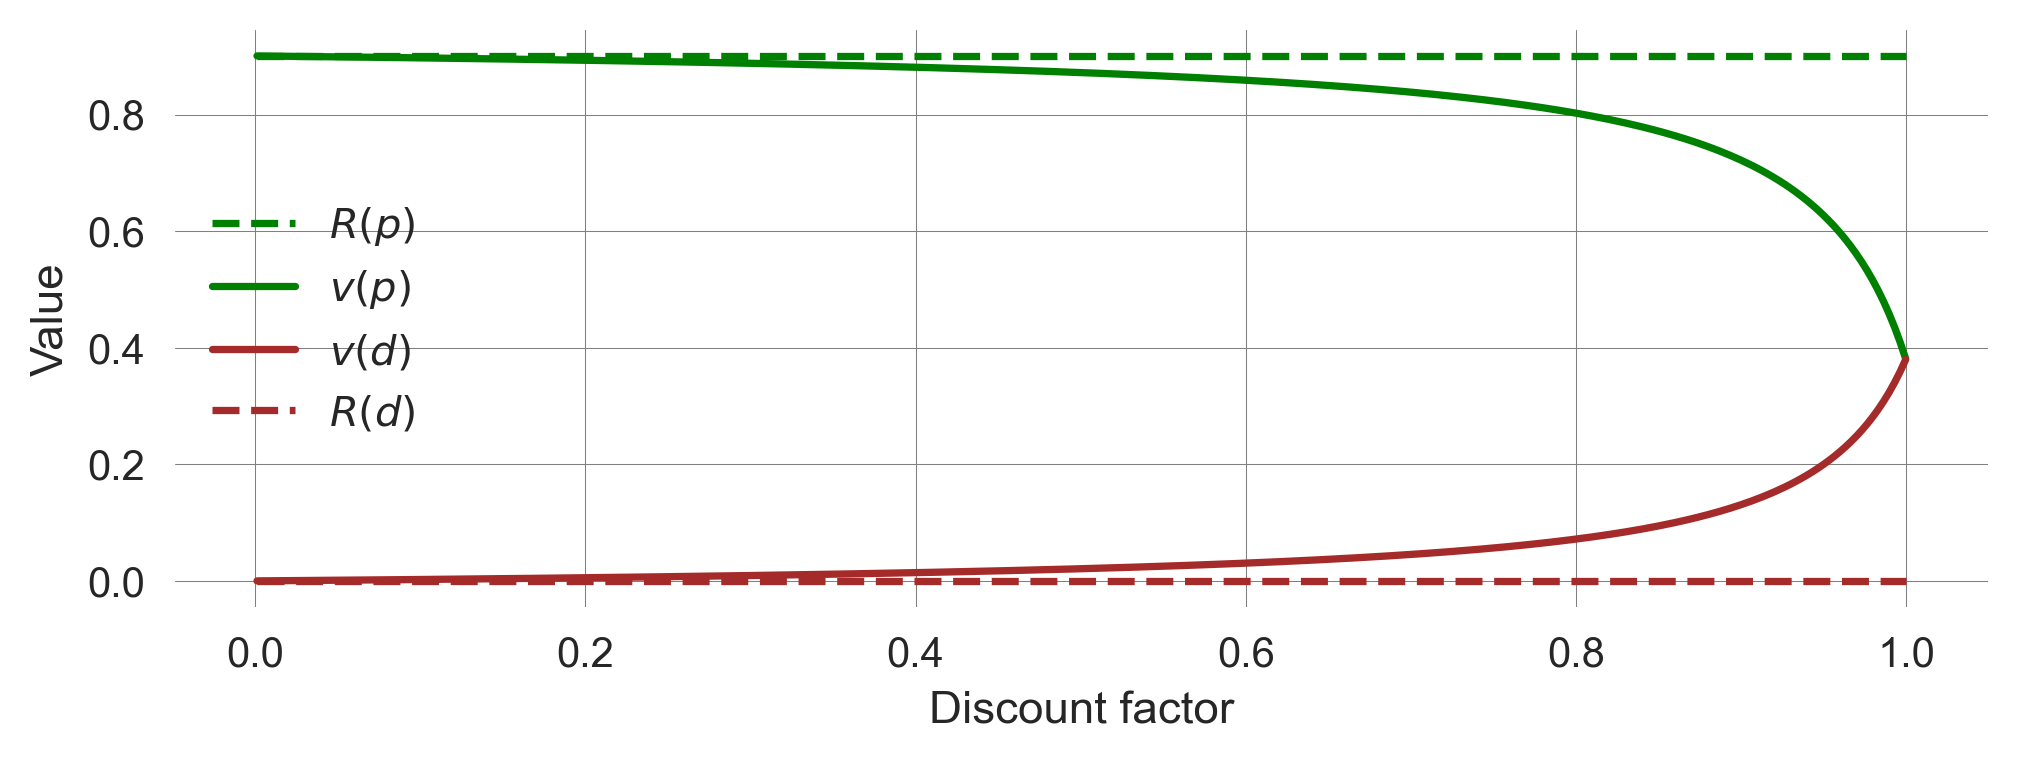

In [49]:
plt.plot(discountfactors, Rs[0]*np.ones_like(discountfactors), label='$R(p)$', c='green', ls='--');
plt.plot(discountfactors, values[:, 0], label='$v(p)$', c='green');
plt.plot(discountfactors, values[:, 1], label='$v(d)$', c='brown');
plt.plot(discountfactors, Rs[1]*np.ones_like(discountfactors), label='$R(d)$', c='brown', ls='--');
plt.legend(); plt.xlabel('Discount factor'); plt.ylabel('Value')

When the discount factor is close to zero, $\gamma=0$, the values equal the average immediate rewards.

When the discount factor $\gamma\rightarrow 1$, the state values for the prosperous and the degraded state approach each other. 

Last, the state values change more for large $\gamma>0.85$ than for lower $\gamma$.

So far, we investigated how to compute the state values for a given policy and use a random policy as an example. To eventually answer what the agent should do, we must compare multiple policies and find the best one.

## Optimal policies

**The key question of our example model is, when is it better to play safe, and when is it better to be risky?** From our model definition, we can easily see that, in the degraded state, it is always better to play safe as this is the only way to recover to the more rewarding, prosperous state. But what about the prosperous state?

### Numerical computation

We define two policies, a **safe** policy, $\mathbf x_{\text{safe}}$, where the agent always chooses the safe action and a **risky** policy, $\mathbf x_{\text{risky}}$, where the agent always chooses the risky action in the prosperous state.

In [50]:
Xsafe = np.array([[1,0],[1,0]])
Xrisk = np.array([[0,1],[1,0]])

For each of these policies, we compute the state values with our `compute_statevalues` function,

In [51]:
V_safe = np.array([compute_statevalues(Xsafe, T, R, dcf) for dcf in discountfactors])
V_risk = np.array([compute_statevalues(Xrisk, T, R, dcf) for dcf in discountfactors])

and plot these values for each policy and each state as

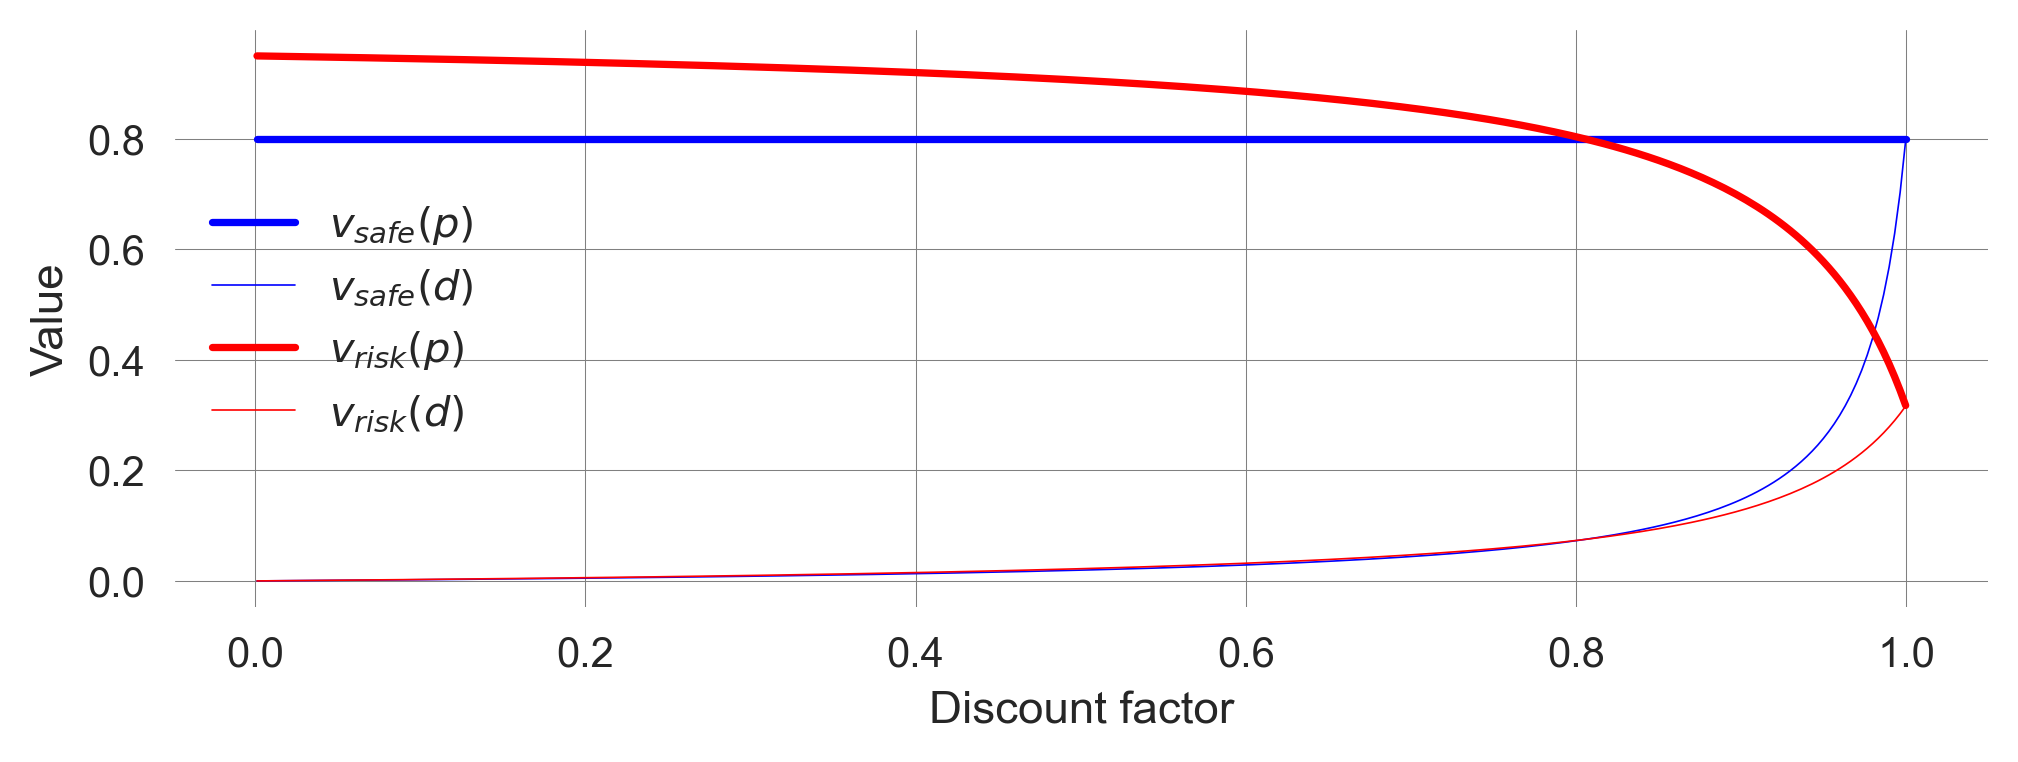

In [52]:
plt.plot(discountfactors, V_safe[:, 0], label='$v_{safe}(p)$', color='blue'); 
plt.plot(discountfactors, V_safe[:, 1], label='$v_{safe}(d)$', color='blue', lw=0.4); 
plt.plot(discountfactors, V_risk[:, 0], label='$v_{risk}(p)$', color='red'); 
plt.plot(discountfactors, V_risk[:, 1], label='$v_{risk}(d)$', color='red', lw=0.4); 
plt.legend(); plt.xlabel('Discount factor'); plt.ylabel('Value');

We find a **critical discount factor** $\hat \gamma$, where the optimal policy changes. Below $\hat\gamma$, the agent acts optimally by choosing the risky policy. Above the critical discount factor, $\hat\gamma$, the agent acts optimally by choosing the safe policy.

Hence, when the agent cares enough about the future, it is better to be safe than sorry, even if this means giving up immediate, short-term welfare ($r_s < r_r$).

**But how does this result depend on the other parameters, $p_c, p_r, r_s, r_r, r_d$?**

This investigates how the optimal policy depends on all parameters of the model; we first **define general transition and reward functions** that return a transition and reward tensor, given our model parameters. We make these functions general by passing the most general datatype to the respective `numpy.array`s, i.e., `dtype=object.` This allows us to store arbitrary Python objects in the arrays, such as float numbers or symbolic expressions.

In [53]:
def get_transitions(pc, pr):
    c=0; r=1; p=0; d=1  # for reference we define these as function-local variables
    T = np.zeros((2,2,2), dtype=object)
    T[p,c,d] = 0            # Cautious action guarantees prosperous state
    T[p,c,p] = 1   # 
    T[p,r,d] = pc;          # Risky action risks collapse
    T[p,r,p] = 1-T[p,r,d]   # ... but collapse may not happen
    T[d,c,p] = pr           # Recovery only possible with cautious action 
    T[d,c,d] = 1-T[d,c,p]   # ... but recovery might not happen
    T[d,r,p] = 0            # Risky action remains at degraded state
    T[d,r,d] = 1
    return T

In [54]:
def get_rewards(rs, rr=1, rd=0):
    c=0; r=1; p=0; d=1  # for reference we define these as function-local variables
    R = np.zeros((2,2,2), dtype=object)
    R[p,c,p] = rs            # The cautious action at the prosperous state guarantees the safe reward 
    R[p,r,p] = rr            # The risky action can yield the risky reward if the environment remains at p
    R[d,:,:] = R[:,:,d] = rd # Otherwise, the agent receives rd
    return R

Now, we can create transition and reward tensors flexibly. As we want to perform numerical computations, we specify the data type of the arrays to be float numbers.

In [55]:
T = get_transitions(0.04, 0.1).astype(float)
T

array([[[1.  , 0.  ],
        [0.96, 0.04]],

       [[0.1 , 0.9 ],
        [0.  , 1.  ]]])

In [56]:
R = get_rewards(0.7).astype(float)
R

array([[[0.7, 0. ],
        [1. , 0. ]],

       [[0. , 0. ],
        [0. , 0. ]]])

Let's assume we want to know how the critical discount factor $\hat \gamma$ depends on the collapse probability $p_c$ for a given recovery probability $p_r=0.01$ and safe reward $r_s=0.8$, a risky reward $r_r = 1.0$ and a degraded reward $r_d=0.0$. We define these quantities as

In [57]:
pr = 0.01
rs = 0.5
rr = 1.0
rd = 0.0

and let the discount factor and collapse probabilities run from almost zero to almost one with a resolution of `301` elements,

In [58]:
discountfactors = np.linspace(0.0001, 0.9999, 301)
collapseprobabilities = np.linspace(0.0001, 0.9999, 301)

We will go through each combination of discount factors and collapse probabilities, compute the state values for both policies, compare them, and store the result in a *data container*. We prepare this *data container* by

In [59]:
risky_optimal_data_container = np.zeros((discountfactors.size, collapseprobabilities.size, 2))

Now, we are ready to execute our simulation. We loop through each discount factor and for each discount factor through each collapse probability, obtain our new transition matrix, compute the state values, and store them in our data container. The Jupyter cell magic `%%time` shows us how long it took to execute that cell. 

In [60]:
%%time
for i, dcf in enumerate(discountfactors):
    for j, pc in enumerate(collapseprobabilities):
        T = get_transitions(pc, pr).astype(float)
        R = get_rewards(rs, rr, rd).astype(float)
        Vs_risk = compute_statevalues(Xrisk, T, R, dcf)
        Vs_safe = compute_statevalues(Xsafe, T, R, dcf)
        risky_optimal_data_container[i, j, :] = Vs_risk > Vs_safe

CPU times: user 10.9 s, sys: 1.94 s, total: 12.8 s
Wall time: 8.7 s


We noticeably have to wait for the result!

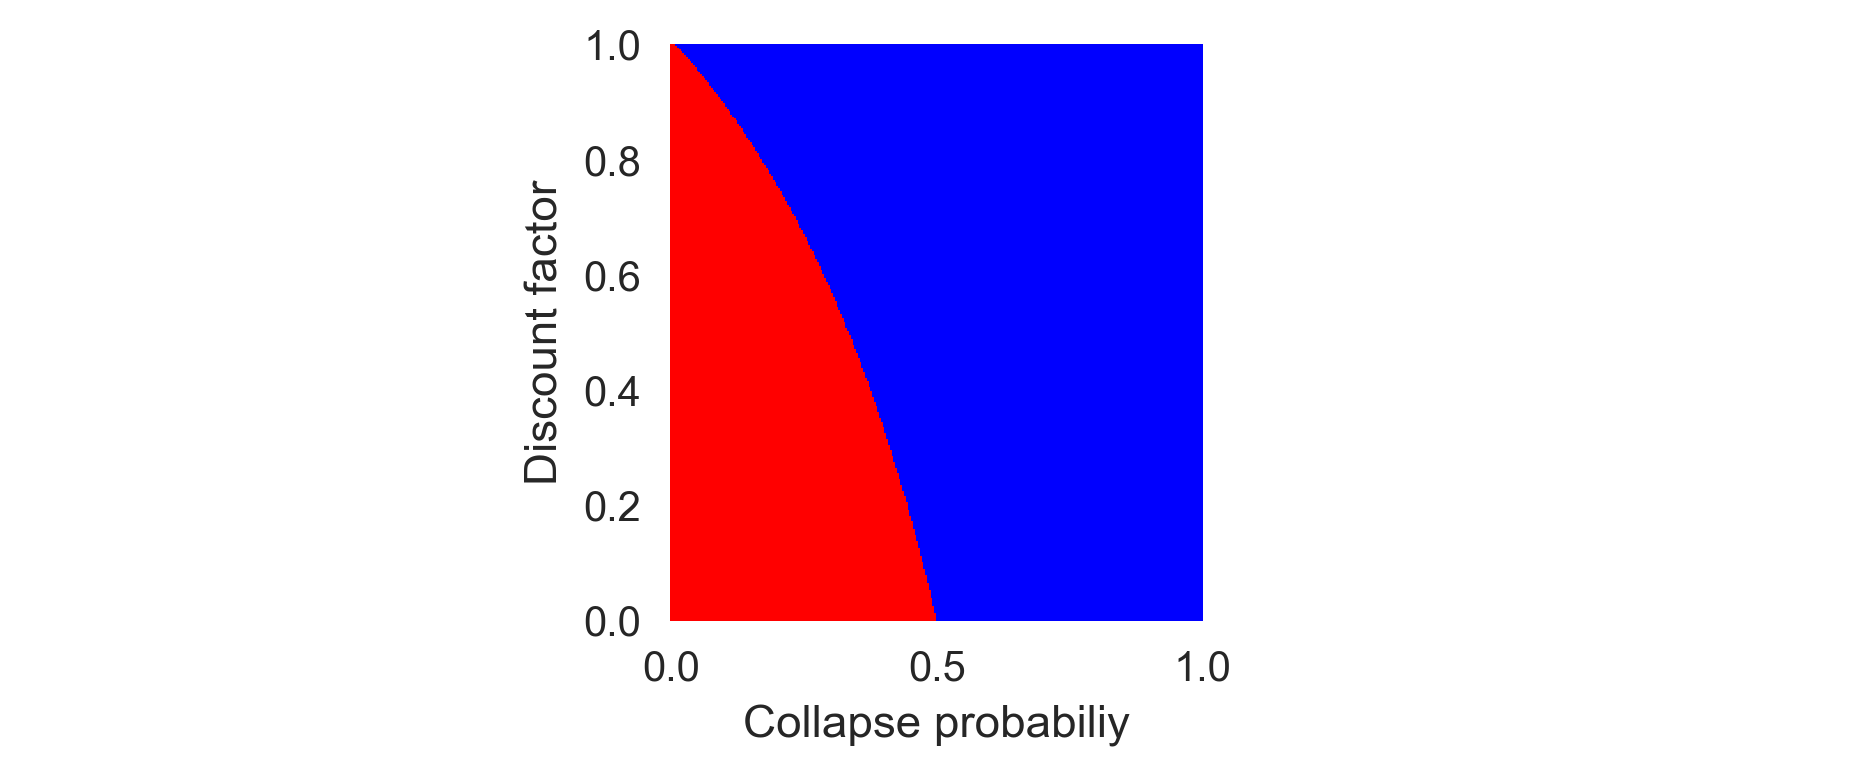

In [61]:
plt.subplot(131); plt.xticks([]); plt.yticks([]); 
plt.subplot(133); plt.xticks([]); plt.yticks([]); 
plt.subplot(132) # just to center the plot in the middle

plt.pcolormesh(collapseprobabilities, discountfactors, 
               risky_optimal_data_container[:,:,0], cmap='bwr')
plt.ylabel('Discount factor'); plt.xlabel('Collapse probabiliy');

**The higher the collapse probability, the lower the critical discount factor.** When the collapse is more likely, less future care is required to evaluate the safe policy as optimal. When the collapse probability is zero ($p_c=0$), the critical discount factor is one ($\hat\gamma=1$), and the agent should always choose the risky policy, as the environment cannot be destroyed. 

When the discount factor is zero ($\gamma=0$), the critical collapse probability is a half $\hat p_c=0.5$. If an environmental collapse under the risky action is more likely $p_c > \hat p_c$, the agent should always choose the safe policy and vice versa. But where does the value $0.5$ come from? Intuitively, it is the ratio between the safe and the risky reward, $r_s/r_r$. 

But how can we be sure? And wouldn't it be great, if we could speed up the computation time somehow?

The solution to both questions lies in a symbolic computation of the critical parameter values $\hat \gamma, \hat p_c, \hat p_r, \hat r_s, \hat r_r, \hat r_d$.

### Symbolic computation

We define symbolic expressions for our model parameters and obtain the corresponding transition and reward tensors,

In [62]:
pc, pr = sp.symbols("p_c, p_r")
T = sp.Array(get_transitions(pc, pr))
T

[[[1, 0], [1 - p_c, p_c]], [[p_r, 1 - p_r], [0, 1]]]

In [63]:
rs, rr, rd = sp.symbols("r_s r_r r_d")
R = sp.Array(get_rewards(rs, rr, rd))
R

[[[r_s, r_d], [r_r, r_d]], [[r_d, r_d], [r_d, r_d]]]

As before, we also define a risky and a safe policy, now as symbolic variables,

In [64]:
Xsafe = sp.Array([[1,0],[1,0]])
Xrisk = sp.Array([[0,1],[1,0]])

and also the discount factor as a symbolic variable

In [65]:
dcf = sp.symbols("gamma")
dcf

gamma

Luckily, we only have to change our `compute_statevalues` slightly, (since the `np.einsum` function also works with Sympy expressions)

In [66]:
def symbolic_statevalues(policy_Xsa, transitions_Tsas, rewards_Rsas, discountfactor=dcf):
    s, a, s_ = 0, 1, 2  # defining indices for convenicence
    Tss = sp.Matrix(np.einsum(policy_Xsa, [s, a], transitions_Tsas, [s, a, s_], [s,s_]))   
    Rs = sp.Array(np.einsum(policy_Xsa, [s, a], transitions_Tsas, [s, a, s_], rewards_Rsas, [s, a, s_], [s]))
    inv = (sp.eye(2) - discountfactor*Tss).inv(); inv.simplify()  # sp.simplify() often helps 
    Vs = (1-discountfactor) * sp.Matrix(np.einsum(inv, [s,s_], Rs, [s_], [s])); Vs.simplify()
    return Vs

The symbolic expressions of the state values for the risky policy are

In [67]:
symbolic_statevalues(Xrisk, T, R)

Matrix([
[(gamma*p_c*p_r*r_d - gamma*p_c*p_r*r_r + gamma*p_c*r_r + gamma*p_r*r_r - gamma*r_r + p_c*r_d - p_c*r_r + r_r)/(gamma*p_c + gamma*p_r - gamma + 1)],
[                    (gamma*p_c*p_r*r_d - gamma*p_c*p_r*r_r + gamma*p_c*r_d + gamma*p_r*r_r - gamma*r_d + r_d)/(gamma*p_c + gamma*p_r - gamma + 1)]])

and for the safe policy, are

In [68]:
symbolic_statevalues(Xsafe, T, R)

Matrix([
[                                                      r_s],
[(gamma*p_r*r_s - gamma*r_d + r_d)/(gamma*p_r - gamma + 1)]])

To check whether the risky policy is optimal, we subtract the value of the safe policy from the risky policy's value at the prosperous state `0`.

In [69]:
risky_optimal = sp.simplify(symbolic_statevalues(Xrisk, T, R)[0])\
    - sp.simplify(symbolic_statevalues(Xsafe, T, R)[0]) 
sp.simplify(risky_optimal)

(gamma*p_c*p_r*r_d - gamma*p_c*p_r*r_r + gamma*p_c*r_r + gamma*p_r*r_r - gamma*r_r + p_c*r_d - p_c*r_r + r_r - r_s*(gamma*p_c + gamma*p_r - gamma + 1))/(gamma*p_c + gamma*p_r - gamma + 1)

We can solve this equation for any variable. For example, to check the critical collapse probability for an entirely myopic agent with zero care for the future, we solve the equation for the collapse probability $p_c$ and substitute the discount factor $\gamma=0$.

In [70]:
sp.solve(risky_optimal, pc)[0].subs(dcf, 0)

(-r_r + r_s)/(r_d - r_r)

Thus, **our initution about the ratio between $r_s$ and $r_r$ was not entirely correct**. In fact, we can simplify the three reward parameters $r_r$, $r_s$, and $r_d$. As it is irrelevant to the agent's decision whether all rewards are multiplied by a factor or all rewards are added by a constant, we can set $r_d=0$ and $r_s=1$ without loss of generality. 

Setting the degraded reward to zero, $r_d=0$, and the risky reward to one, $r_r=1$, improves the transparency and interpretability of the model.

In [71]:
sp.solve(risky_optimal.subs(rr, 1).subs(rd, 0), pc)[0].subs(dcf, 0)

1 - r_s

Thus, the critical collapse probability $\hat p_c$ for $\gamma =0$ is given by the $\hat p_c = 1-r_s$.

**By using symbolic calculations, we improve the transparency and interpretability of our model.**

How can we speed up the computation time with `sympy`?

### Efficient computation

To create a plot as above, it is an excellent strategy to **convert this symbolic expression into a numeric function**. In `sympy,` this is done with the `sympy.lambdify` function, (called as `sp.lambdify((<symbolic parameters>), <symbolic expression to be turned into a numeric function>`)

In [72]:
risky_optimal_func = sp.lambdify((pc,pr,dcf,rs,rr,rd), risky_optimal)

For example, we can now execute `risky_optimal_func` for $p_c=0.2$, $p_r=0.01$, $\gamma=0.9$, $r_s=0.5$, $r_r=1.0$, and $r_d=0.0$ as

In [73]:
risky_optimal_func(0.2, 0.01, 0.9, 0.5, 1.0, 0.0)

-0.19826989619377183

and learn that the risky policy is *not* optimal in this case.

However, the big advantage of a *lambdified* function is that we can apply it in **vectorized form**. This means the parameters don't have to be single numbers. They can be vectors or even larger tensors. See, for example,

In [74]:
gams = np.linspace(0.0001, 0.9999, 9)
risky_optimal_func(0.2, 0.01, gams, 0.5, 1.0, 0.0)

array([ 0.299984  ,  0.27779382,  0.25014334,  0.21473437,  0.1677686 ,
        0.10248474,  0.00556964, -0.15331544, -0.46154209])

Thus, to recreate our example from above, where we wanted to know how the critical discount factor $\hat\gamma$ depends on the collapse probability $p_c$ for given other parameters, we can now use the `risky_optimal_func` directly in vectorized form.

However, if we simply put two vectors (of the same dimension) inside the function, we only get

In [75]:
discountfactors = np.linspace(0.0001, 0.9999, 9)
collapseprobabilities = np.linspace(0.0001, 0.9999, 9)
risky_optimal_func(collapseprobabilities, 0.01, discountfactors, 0.5, 1.0, 0.0)

array([ 0.49989999,  0.3595776 ,  0.19241376,  0.01072705, -0.16556291,
       -0.31475139, -0.42146066, -0.48138804, -0.499999  ])

we only get one vector (of the same dimension) out. This is, beacuse vectorization groups changes along a dimension together.

This means we need to separate the variation in the discount factors (in `discountfactors`) and the variation in the collapse probabilities (in `collapseprobabilities`) into different dimensions. Luckily, we don't have to do that manually. The `numpy` method `numpy.meshrid` exactly fits this purpose. For example,

In [76]:
discountfactors = [0.8, 0.9]
collapseprobabilities = [0.1, 0.2, 0.3]
np.meshgrid(discountfactors, collapseprobabilities)

[array([[0.8, 0.9],
        [0.8, 0.9],
        [0.8, 0.9]]),
 array([[0.1, 0.1],
        [0.2, 0.2],
        [0.3, 0.3]])]

In practise, we can use a meshgrid as follows,

In [77]:
pr_ = 0.01
rs_ = 0.5
rr_ = 1.0
rd_ = 0.0
discountfactors = np.linspace(0.0001, 0.9999, 301)
collapseprobabilities = np.linspace(0.0001, 0.9999, 301)
DCFs, PCs = np.meshgrid(discountfactors, collapseprobabilities)

In [78]:
risky_optimal_func(PCs, pr_, DCFs, rs_, rr_, rd_)

array([[ 0.49989999,  0.49989966,  0.49989932, ...,  0.49398743,
         0.49251766,  0.49009707],
       [ 0.49656699,  0.49655555,  0.49654403, ...,  0.32758543,
         0.29387422,  0.24378043],
       [ 0.49323399,  0.49321152,  0.4931889 , ...,  0.20822659,
         0.1607447 ,  0.09481031],
       ...,
       [-0.49323534, -0.49325773, -0.49328013, ..., -0.4998874 ,
        -0.49990965, -0.4999319 ],
       [-0.49656768, -0.49657908, -0.49659048, ..., -0.49994305,
        -0.49995431, -0.49996556],
       [-0.49990001, -0.49990034, -0.49990068, ..., -0.49999835,
        -0.49999867, -0.499999  ]])

Notice how quickly that was compared to our previous calculations!

To time how long the cell execution takes more precisely, we can use the `%%timeit` cell magic command:

In [79]:
%%timeit
risky_optimal_func(PCs, pr_, DCFs, rs_, rr_, rd_)

1.92 ms ± 396 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


It executes the cell multiple times and presents us with a short summary statistic. Compare the average runtime of the cell with the numerical computation. It is around 5000 times faster!

Thus, we can summarize the lambdified `sympy` expression into a `plot_parameter_space` function:

In [80]:
def plot_parameter_space(safe_reward=0.5, risky_reward=1.0, degraded_reward=0.0, recov_prop=0.05):
    plt.subplot(131); plt.xticks([]); plt.yticks([]); 
    plt.subplot(133); plt.xticks([]); plt.yticks([]); 
    plt.subplot(132) # just to center the plot in the middle
    
    resolution=251
    
    X = np.linspace(0.0001, 0.9999, resolution)
    Y = np.linspace(0.0001, 0.9999, resolution)
    XX, YY = np.meshgrid(X, Y)

    ro = risky_optimal_func(XX, recov_prop, YY, safe_reward, risky_reward, degraded_reward)
    plt.pcolormesh(XX, YY, ro, cmap='bwr', vmin=-0.1, vmax=0.1)
    plt.ylabel('Discount factor'); plt.xlabel('Collapse leverage');

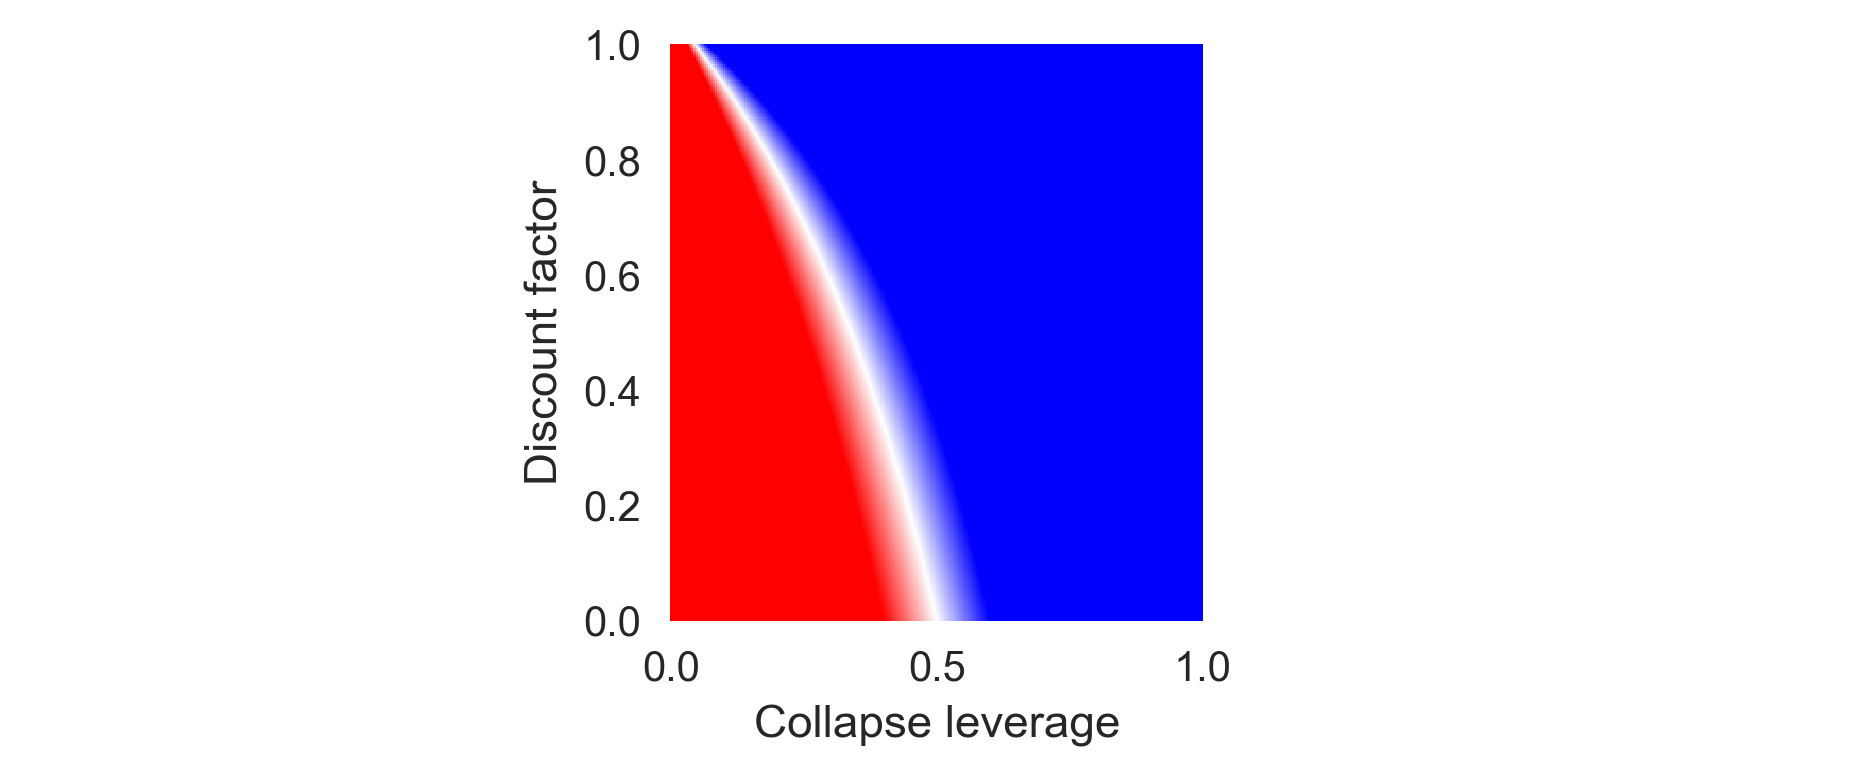

In [81]:
plot_parameter_space()

When working with this Jupyter Notebook directly, we can interactively explore the parameter space of the model.

::: {.content-hidden unless-profile="interactive"}

The fast execution speed of the lambidfied `sympy` expressions allow us to even interact with our model.

In [82]:
interact(plot_parameter_space, safe_reward=(0.01, 1., 0.005), degraded_reward=fixed(0), 
         risky_reward=fixed(1), recov_prop=(0., 1., 0.005));

interactive(children=(FloatSlider(value=0.5, description='safe_reward', max=1.0, min=0.01, step=0.005), FloatS…

:::

For an agent that does not discount the future at all, i.e., with $\gamma \rightarrow 1$, the critical collapse leverage yields,

In [83]:
sp.simplify(sp.solve(risky_optimal.subs(rr,1).subs(rd, 0), pc)[0].subs(dcf, 1))

p_r*(1 - r_s)/(p_r + r_s)

Thus, if there is zero recovery probability $p_r=0$, the safe policy is optimal regardless of the relative reward $0<r_s<1$. 

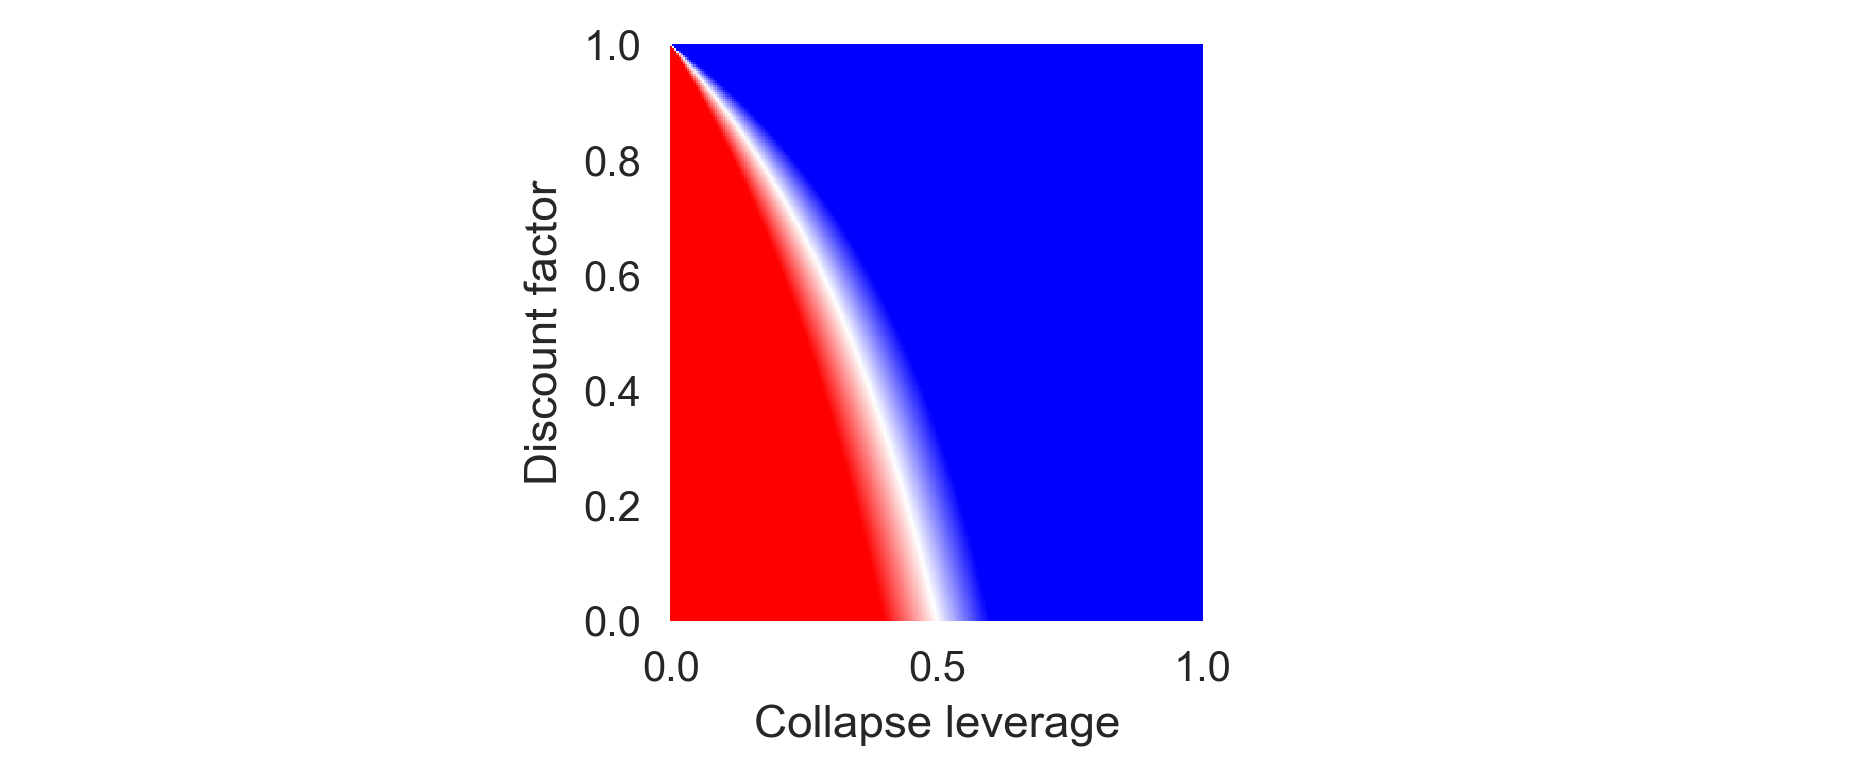

In [84]:
plot_parameter_space(recov_prop=0.0)

If $p_r > 0$, then it depends on the relative reward $r_s$ whether the safe or the risky policy is optimal for a fully farsighted agent.

**Taken together, by using symbolic computation from the `sympy` package, we improve interpretability, transparancey and computational efficiency of our model.**

## Learning goals **revisited**

* We **introduced** the elements of a Markov Decision Process (MDP) and discussed how they relate to applications in human-environment interactions
* We **simulateed** and **visualized** the time-evolution of an MDP.
* We **covered** what value functions are, why they are usful and how to realte to the agent's goal and Bellman equation.
* We **computed** value functions *in serveral ways* and **visualized** how the best policy depends on other model parameters.




::: {.content-hidden unless-profile="standalone"}

## References

:::

::: {.content-hidden unless-profile="housekeeping"}

## Housekeeping

With the following cells, we can convert this notebook into slides and a PDF handout. If you work with this notebook interactively, you can ignore them.

In [85]:
#!jupyter nbconvert 03.01-SequentialDecisions.ipynb --to slides --embed-images --output-dir "./__slides"

---
metadata-files: [_standalone-quarto.yml]
---

In [86]:
#| output: false 
!cp 03.01-SequentialDecisions.ipynb 03.01-SequentialDecisions_.ipynb
!quarto render 03.01-SequentialDecisions_.ipynb --to pdf --profile standalone
!mv 03.01-SequentialDecisions_.pdf __scripts/03.01-SequentialDecisions.pdf
!rm -r 03.01-SequentialDecisions_*

pandoc 
  to: latex
  output-file: 03.01-SequentialDecisions_.tex
  standalone: true
  pdf-engine: xelatex
  variables:
    graphics: true
    tables: true
    secnumdepth: 2
  default-image-extension: pdf
  metadata-files:
    - _standalone-quarto.yml
  toc-depth: 2
  
metadata
  documentclass: scrartcl
  classoption:
    - DIV=11
    - numbers=noendperiod
  papersize: A4
  header-includes:
    - '\KOMAoption{captions}{tableheading}'
  block-headings: false
  title: Sequential Decisions
  bibliography:
    - CSMofHEI.bib
  geometry:
    - top=20mm
    - left=20mm
    - right=20mm
    - bottom=25mm
  link-citations: true
  number-depth: 2
  
WARNING (/Applications/quarto/share/filters/main.lua:12107) Unable to resolve crossref @eq-bellman1

Rendering PDF
running xelatex - 1
  This is XeTeX, Version 3.14159265-2.6-0.999992 (TeX Live 2020) (preloaded format=xelatex)
   restricted \write18 enabled.
  entering extended mode
  
running xelatex - 2
  This is XeTeX, Version 3.14159265-2.6-0.9

:::